# Библиотеки и функции

In [1]:
pip install transformers

     |████████████████████████████████| 2.9 MB 9.8 MB/s 
     |████████████████████████████████| 636 kB 61.8 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 3.3 MB 45.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [1]:
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab2

Mounted at /content/drive
/content/drive/MyDrive/Colab2


In [3]:
import tensorflow as tf
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

In [4]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Настройка

In [5]:
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [6]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Данные

In [7]:
twitter = pd.read_csv('twitter main.csv',index_col=0)
sentences = twitter['content'].tolist()
labels = []
for r in twitter['returns'].tolist():
    if r>0:
        labels +=[1]
    else:
        labels +=[0]

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
print(' Original: ', sentences[0])

print('Tokenized: ', tokenizer.tokenize(sentences[0]))

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  fan stablecoins tbh carry many risk cryptocurrencies also small risk government currency 
Tokenized:  ['fan', 'stable', '##co', '##ins', 'tb', '##h', 'carry', 'many', 'risk', 'crypt', '##oc', '##ur', '##ren', '##cies', 'also', 'small', 'risk', 'government', 'currency']
Token IDs:  [5470, 6540, 3597, 7076, 26419, 2232, 4287, 2116, 3891, 19888, 10085, 3126, 7389, 9243, 2036, 2235, 3891, 2231, 9598]


In [10]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent[:512], add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  206


In [11]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(sent, add_special_tokens = True,max_length = 64, pad_to_max_length = True, return_attention_mask = True,  return_tensors = 'pt',)
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  fan stablecoins tbh carry many risk cryptocurrencies also small risk government currency 
Token IDs: tensor([  101,  5470,  6540,  3597,  7076, 26419,  2232,  4287,  2116,  3891,
        19888, 10085,  3126,  7389,  9243,  2036,  2235,  3891,  2231,  9598,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [12]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))


63,275 training samples
7,031 validation samples


# Модель

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size )

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [ ]:
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

total_t0 = time.time()
for epoch_i in range(0, epochs):
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0


    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        m_res_prom= model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = m_res_prom['loss']
        logits = m_res_prom['logits']

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            m_res_prom = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = m_res_prom['loss']
            logits = m_res_prom['logits']
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,978.    Elapsed: 0:00:08.
  Batch    80  of  1,978.    Elapsed: 0:00:17.
  Batch   120  of  1,978.    Elapsed: 0:00:25.
  Batch   160  of  1,978.    Elapsed: 0:00:34.
  Batch   200  of  1,978.    Elapsed: 0:00:42.
  Batch   240  of  1,978.    Elapsed: 0:00:50.
  Batch   280  of  1,978.    Elapsed: 0:00:59.
  Batch   320  of  1,978.    Elapsed: 0:01:07.
  Batch   360  of  1,978.    Elapsed: 0:01:16.
  Batch   400  of  1,978.    Elapsed: 0:01:24.
  Batch   440  of  1,978.    Elapsed: 0:01:32.
  Batch   480  of  1,978.    Elapsed: 0:01:41.
  Batch   520  of  1,978.    Elapsed: 0:01:49.
  Batch   560  of  1,978.    Elapsed: 0:01:57.
  Batch   600  of  1,978.    Elapsed: 0:02:06.
  Batch   640  of  1,978.    Elapsed: 0:02:14.
  Batch   680  of  1,978.    Elapsed: 0:02:22.
  Batch   720  of  1,978.    Elapsed: 0:02:31.
  Batch   760  of  1,978.    Elapsed: 0:02:39.
  Batch   800  of  1,978.    Elapsed: 0:02:48.
  Batch   840  of

In [ ]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.69,0.69,0.50,0:06:53,0:00:14
2,0.69,0.69,0.50,0:06:52,0:00:14
3,0.69,0.70,0.51,0:06:56,0:00:13
4,0.67,0.70,0.51,0:06:56,0:00:13


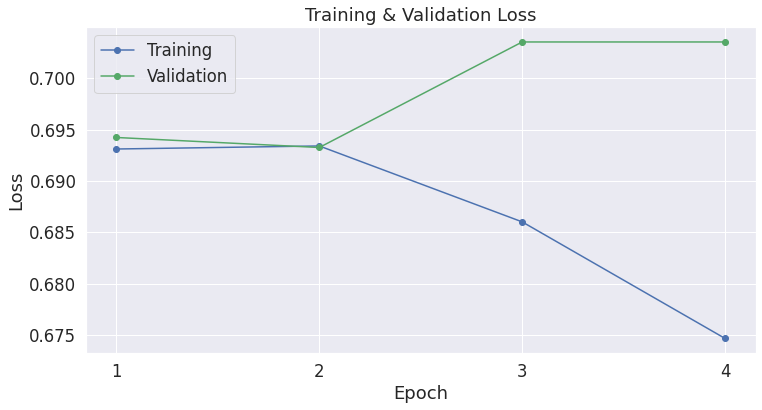

In [ ]:
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [13]:
batch_size = 200
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size )
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size )

In [14]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [16]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [17]:
epochs = 50
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [18]:
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

total_t0 = time.time()
for epoch_i in range(0, epochs):
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0


    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        m_res_prom= model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = m_res_prom['loss']
        logits = m_res_prom['logits']

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            m_res_prom = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = m_res_prom['loss']
            logits = m_res_prom['logits']
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 50 ========
Training...
  Batch    40  of    317.    Elapsed: 0:00:44.
  Batch    80  of    317.    Elapsed: 0:01:27.
  Batch   120  of    317.    Elapsed: 0:02:10.
  Batch   160  of    317.    Elapsed: 0:02:54.
  Batch   200  of    317.    Elapsed: 0:03:37.
  Batch   240  of    317.    Elapsed: 0:04:20.
  Batch   280  of    317.    Elapsed: 0:05:04.

  Average training loss: 0.70
  Training epcoh took: 0:05:43

Running Validation...
  Accuracy: 0.51
  Validation Loss: 0.69
  Validation took: 0:00:12

======== Epoch 2 / 50 ========
Training...
  Batch    40  of    317.    Elapsed: 0:00:43.
  Batch    80  of    317.    Elapsed: 0:01:27.
  Batch   120  of    317.    Elapsed: 0:02:10.
  Batch   160  of    317.    Elapsed: 0:02:53.
  Batch   200  of    317.    Elapsed: 0:03:37.
  Batch   240  of    317.    Elapsed: 0:04:20.
  Batch   280  of    317.    Elapsed: 0:05:03.

  Average training loss: 0.69
  Training epcoh took: 0:05:43

Running Validation...
  Accuracy: 0.51

In [19]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.70,0.69,0.51,0:05:43,0:00:12
2,0.69,0.69,0.51,0:05:43,0:00:12
3,0.69,0.69,0.51,0:05:43,0:00:12
4,0.69,0.71,0.51,0:05:43,0:00:12
5,0.64,0.76,0.50,0:05:44,0:00:12
6,0.55,0.85,0.50,0:05:44,0:00:12
7,0.47,0.89,0.50,0:05:44,0:00:12
8,0.40,1.09,0.50,0:05:44,0:00:12
9,0.35,1.22,0.50,0:05:44,0:00:12


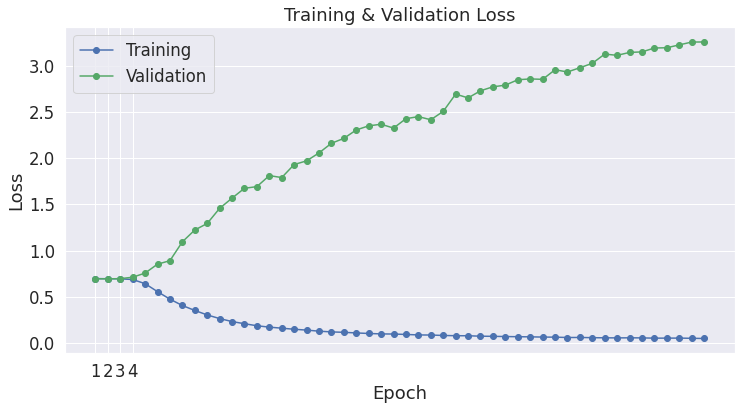

In [20]:
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [2]:
pip install transformers

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 65.6 MB/s 
     |████████████████████████████████| 3.3 MB 60.4 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |████████████████████████████████| 636 kB 77.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
pip install squarify

In [4]:
pip install apyori

  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=2f824db9d3b7042a9ab3d234ca150ed38e5a278383e26ff262f23823735ae879
  Stored in directory: /root/.cache/pip/wheels/cb/f6/e1/57973c631d27efd1a2f375bd6a83b2a616c4021f24aab84080
Successfully built apyori


In [5]:
pip install scikit-multilearn

     |████████████████████████████████| 89 kB 3.7 MB/s 


In [6]:
pip install keras

In [7]:
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import decomposition
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.metrics import f1_score, accuracy_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer


from scipy import linalg
import networkx as nx

from collections import Counter, defaultdict
import pickle

import nltk
nltk.download('wordnet')
from nltk import stem
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer

from gensim import matutils, models
from gensim.models import Word2Vec
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import scipy.sparse

from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
import squarify
from skmultilearn.problem_transform import BinaryRelevance, LabelPowerset

import warnings
warnings.filterwarnings('ignore')

from apyori import apriori

from mlxtend.preprocessing import TransactionEncoder
from multiprocessing import  Pool

import transformers

import tensorflow as tf
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [24, 12]
plt.style.use('seaborn-darkgrid')

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def regular_encode(texts, tokenizer, maxlen = 512):
    enc_di = tokenizer.batch_encode_plus(texts,return_token_type_ids = False, pad_to_max_length = True, max_length = maxlen)
    return np.array(enc_di['input_ids'])

In [9]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [10]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS available: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.7.154.186:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.7.154.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.7.154.186:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS available:  8


In [11]:
twitter = pd.read_csv('twitter main.csv',index_col=0)#.iloc[:1000]

In [12]:
labels = []
for r in twitter['returns'].tolist():
    if r>0:
        labels +=[1]
    else:
        labels +=[0]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(twitter['content'].tolist(), labels, random_state = 22, test_size = 0.1)

In [14]:
Xtrain_encoded = regular_encode(X_train, tokenizer, maxlen = 512)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 2, dtype = 'int32')
Xtest_encoded = regular_encode(X_test, tokenizer, maxlen = 512)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 2, dtype = 'int32')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
def build_model(transformer, loss = 'categorical_crossentropy', max_len = 512):
    input_word_ids = tf.keras.layers.Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]

    x = tf.keras.layers.Dropout(0.40)(cls_token)

    out = tf.keras.layers.Dense(2, activation = 'sigmoid')(x)

    model = tf.keras.Model(inputs = input_word_ids, outputs = out)
    model.compile(tf.keras.optimizers.Adam(lr = 1e-8), loss = loss, metrics = ['accuracy'])
    return model

In [16]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len = 512)
model.summary()

DEBUG:filelock:Attempting to acquire lock 139793513278544 on /root/.cache/huggingface/transformers/4227924573c09a29255e529b6636de7bfdfc5e1094daed2d2be04e96db5a7a36.cf99ee297384bd78d0676a0dbe78da2a4928e3a435e38f17ea1b1a855b3eb992.h5.lock
DEBUG:filelock:Lock 139793513278544 acquired on /root/.cache/huggingface/transformers/4227924573c09a29255e529b6636de7bfdfc5e1094daed2d2be04e96db5a7a36.cf99ee297384bd78d0676a0dbe78da2a4928e3a435e38f17ea1b1a855b3eb992.h5.lock


Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

DEBUG:filelock:Attempting to release lock 139793513278544 on /root/.cache/huggingface/transformers/4227924573c09a29255e529b6636de7bfdfc5e1094daed2d2be04e96db5a7a36.cf99ee297384bd78d0676a0dbe78da2a4928e3a435e38f17ea1b1a855b3eb992.h5.lock
DEBUG:filelock:Lock 139793513278544 released on /root/.cache/huggingface/transformers/4227924573c09a29255e529b6636de7bfdfc5e1094daed2d2be04e96db5a7a36.cf99ee297384bd78d0676a0dbe78da2a4928e3a435e38f17ea1b1a855b3eb992.h5.lock
Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification m

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_bert_model (TFBertModel)  TFBaseModelOutputWithPool 335141888 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1024)              0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 335,143,938
Trainable params: 335,143,938
Non-trainable params: 0
_________________________________________________________________


In [19]:
BATCH_SIZE = 64#32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (tf.data.Dataset.from_tensor_slices((Xtrain_encoded, ytrain_encoded)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))
test_dataset = (tf.data.Dataset.from_tensor_slices(Xtest_encoded).batch(BATCH_SIZE))

In [20]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(train_dataset, steps_per_epoch = n_steps, epochs = 20)

Epoch 1/20
988/988 [==============================] - 912s 824ms/step - loss: 0.8616 - accuracy: 0.4992
Epoch 2/20
988/988 [==============================] - 814s 824ms/step - loss: 0.8178 - accuracy: 0.5026
Epoch 3/20
988/988 [==============================] - 814s 824ms/step - loss: 0.7996 - accuracy: 0.4990
Epoch 4/20
988/988 [==============================] - 814s 824ms/step - loss: 0.7879 - accuracy: 0.4993
Epoch 5/20
988/988 [==============================] - 814s 824ms/step - loss: 0.7783 - accuracy: 0.5040
Epoch 6/20
988/988 [==============================] - 814s 824ms/step - loss: 0.7759 - accuracy: 0.4993
Epoch 7/20
988/988 [==============================] - 815s 824ms/step - loss: 0.7717 - accuracy: 0.5031
Epoch 8/20
988/988 [==============================] - 815s 825ms/step - loss: 0.7684 - accuracy: 0.4989
Epoch 9/20
988/988 [==============================] - 815s 825ms/step - loss: 0.7634 - accuracy: 0.5019
Epoch 10/20
988/988 [==============================] - 815s 824m

In [21]:
preds = model.predict(test_dataset, verbose = 1)
pred_classes = np.argmax(preds, axis = 1)

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 512) dtype=int64>]


110/110 [==============================] - 59s 472ms/step


In [22]:
print('Prediction Accuracy on Validation dataset: ', np.round(100*accuracy_score(pred_classes, y_test), 2), '%')

Prediction Accuracy on Validation dataset:  50.09 %
